# The Art of Symmetry: Incorporating Alternative Data into your Portfolio Rebalancing
\[_In case you’re unable to see the Atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/atoti/blob/main/03-use-cases/01-finance/portfolio-management/alt-data/main.ipynb)._]

Last tested version: <img src="https://img.shields.io/badge/Atoti-v0.8.4-blue">


It's no secret that access to the right data along with the right aggregation engine allows Quants and portfolio managers to achieve their goals. The problem? How do you find good data, and what is the right aggregation tool?  

This notebook is a collaboration between [Atoti Community](https://www.atoti.io) and [CloudQuant](https://www.cloudquant.com/).


<center><img src="https://data.atoti.io/notebooks/banners/AtotiCommunity.png" alt="Atoti Community" style="height: 100px;" hspace="50"></a></div><img src="https://data.atoti.io/notebooks/alt-data/img/CloudQuantPNGLogo.png" alt="CloudQuant" style="height: 100px;" hspace="50"></a></div></center>

## Getting Started with Atoti and CloudQuant

Discover how seamless it can be to incorporate alternative data into your rebalancing act. With CloudQuant’s datasets and Atoti Python API, we show you how to keep alternative data in mind when working through monthly portfolio rebalancing.

In this notebook, we demonstrate how, using [Atoti Python API](https://docs.atoti.io/) and [CloudQuant's Liberator API](https://www.cloudquant.com/data-liberator/), we can incorporate alternative data in our portfolio rebalancing. Specifically, we demonstrate how to:

1. Create a portfolio using Alphaflow
2. Compute returns using DailyBars in Atoti
3. Rebalance it monthly using Alphaflow long term signals
4. Subject to several ESG related constraints using ESG data
5. Compare across your portfolio options

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=alt-data" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try atoti"></a></div>

This notebook example utilizes custom widgets in our dasboards. By setting the below variable to `True`, we can view features not available in the Community Edition, like customized widgets for Atoti UI. Setting the below variable to `False` will continue to use Atoti Community Edition. No additional licensing setup is required.

**Want to try Atoti Python API? You can [register online for an evaluation license](https://atoti.io/evaluation-license-request/) and check out how to [unlock all features of Atoti](https://docs.atoti.io/latest/how_tos/unlock_all_features.html).**

<img src="https://img.shields.io/badge/-Atoti%20CE-%23291A40" /> 🔛 <img src="https://img.shields.io/badge/🔒-Atoti-291A40" />  

Switch from Atoti Community Edition to Atoti Python API by updating the below variable to `True`. 

In [1]:
atoti_unlock = False

Below shows the configuration(s) required to register the custom widgets in this use case.  

In [2]:
ui_ext = (
    {
        "optimizerwidget-extension": "./ui/packages/optimizerWidget/dist/",
    }
    if atoti_unlock
    else {}
)

content = "./content" if atoti_unlock else "./content-atoti-ce"

In [3]:
import zipfile

import atoti as tt
import pandas as pd
import wget
from IPython.display import clear_output, display
from utils.mapping import esg_col_types, esg_cols

In [4]:
def bar_custom(current, total, width=80):
    clear_output(wait=True)
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))


url = "https://data.atoti.io/notebooks/alt-data/liberator-data.zip"
filename = wget.download(url, bar=bar_custom)

# unzipping the file
with zipfile.ZipFile("liberator-data.zip", "r") as zip_ref:
    zip_ref.extractall()

Downloading: 100% [2056595 / 2056595] bytes


In [5]:
session = tt.Session(
    user_content_storage=content,
    java_options=["-Xms1G", "-Xmx8G"],
    port=9092,
    app_extensions=ui_ext,
)

### Data modeling

We can now create our data model based on the information we know we'll be working with. At the minimum, we will have portfolios we want to manage, the daily pricing data for the stocks or symbols we manage, and, since we are considering including alternative data in this use case, the alternative data we will be weaving in.

In [6]:
portfolios = session.create_table(
    name="portfolios",
    types={
        "portfolio": tt.STRING,
        "symbol": tt.STRING,
        "weight": tt.DOUBLE,
        "iteration": tt.STRING,
        "method": tt.STRING,
    },
    default_values={"iteration": "base", "method": "base"},
    keys=["portfolio", "symbol", "iteration", "method"],
)

In [7]:
daily_bars_array = session.create_table(
    name="daily_bars_array",
    types={
        "symbol": tt.STRING,
        "closing_price": tt.DOUBLE_ARRAY,
        "daily_returns_vector": tt.DOUBLE_ARRAY,
        "daily_ROR_vector": tt.DOUBLE_ARRAY,
        "monthly_ROR_vector": tt.DOUBLE_ARRAY,
    },
    keys=["symbol"],
)

In [8]:
historical_dates = session.create_table(
    name="historical_dates",
    types={
        "historical_date": tt.LOCAL_DATE,
        "date_index": tt.INT,
        "monthly_date_index": tt.INT,
    },
    keys=["historical_date"],
    default_values={"date_index": -1, "monthly_date_index": -1},
)

In [9]:
gsq_measure_large_cap = session.create_table(
    name="gsq_measure_large_cap",
    types=esg_col_types,
    keys=["symbol", "report_date"],
)

In [10]:
cube = session.create_cube(portfolios, "esg_optimization")

In [11]:
portfolios.join(daily_bars_array)
portfolios.join(historical_dates)

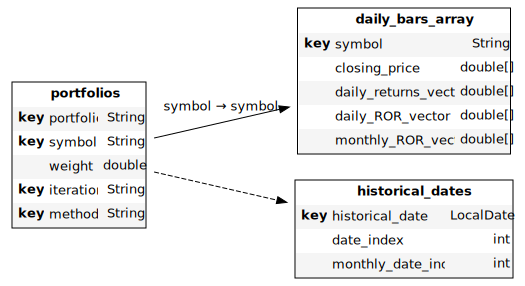

In [12]:
cube.schema

In [13]:
portfolios.join(gsq_measure_large_cap)

In [14]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### Loading in data from Liberator

Alternatively, if we have an active license from CloudQuant, we can just as readily query and read in the results from Liberator. To see an example of querying datasets using the Liberator API, check out [01_data_gen notebook](./01_data_gen.ipynb) or see [Liberator's documentation](https://www.cloudquant.com/data-liberator/).

In [15]:
daily_bars_array.load_csv("./data/array/daily_bars.csv", array_separator=",")

In [16]:
gsq_measure_large_cap.load_csv(
    "./data/gsq_measure_large_cap.csv",
    columns=esg_cols,
)

In [17]:
portfolios.load_csv("./data/portfolio.csv")

In [18]:
historical_dates.load_csv("./data/array/historical_dates.csv")

## Exploring our data

In [19]:
session.visualize("Our Starting Portfolios")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

## Hierarchies and Measures
When we created our cube, we didn't specify the [`mode`](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.create_cube), so it used the default, which is *auto* mode. That means it created hierarchies for every non-numerical column, and a mean and sum measure for the numerical columns of our base table. We need more than this, though, and so we'll create additional measures and hierarchies here.

In [20]:
m["closing_price"] = tt.agg.single_value(daily_bars_array["closing_price"])
m["daily_returns_vector"] = tt.agg.single_value(
    daily_bars_array["daily_returns_vector"]
)
m["daily_ROR_vector"] = tt.agg.single_value(daily_bars_array["daily_ROR_vector"])
m["monthly_ROR_vector"] = tt.agg.single_value(daily_bars_array["monthly_ROR_vector"])

In [21]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

### VaR

In [22]:
m["Simulated Portfolio Returns Vector"] = tt.agg.sum(
    portfolios["weight"] * daily_bars_array["daily_ROR_vector"]
)

m["unweighted_ROR_vector"] = tt.agg.sum(daily_bars_array["daily_ROR_vector"])

In [23]:
confidence_levels = cube.create_parameter_simulation(
    "Confidence Level",
    measures={"Confidence Level": 0.95},
    base_scenario_name="95%",
)

In [24]:
confidence_levels += ("90%", 0.90)
confidence_levels += ("98%", 0.98)

In [25]:
m["VaR"] = tt.array.quantile(
    m["Simulated Portfolio Returns Vector"],
    (1 - m["Confidence Level"]),
    interpolation="lower",
)
m["VaR"].formatter = "DOUBLE[#,##0.000%]"

### CVaR

In [26]:
m["Number of Tail Exposures"] = tt.math.floor(
    (1 - m["Confidence Level"]) * tt.array.len(m["Simulated Portfolio Returns Vector"])
)
m["CVaR"] = tt.array.mean(
    tt.array.n_lowest(
        m["Simulated Portfolio Returns Vector"], m["Number of Tail Exposures"]
    )
)

# unweighted
m["symbol_CVaR"] = tt.array.mean(
    # tt.array.n_lowest(m["Daily_ROR_Vector"], m["Number of Tail Exposures"])
    tt.array.n_lowest(m["unweighted_ROR_vector"], m["Number of Tail Exposures"])
)

m["CVaR"].formatter = "DOUBLE[#,##0.000%]"
m["symbol_CVaR"].formatter = "DOUBLE[#,##0.000%]"

In [27]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

In [28]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

### Expected Returns

In [29]:
frequency = 41

# we exclude the first date as this value is dropped in optimizer
m["Expected returns"] = tt.agg.sum(
    tt.array.prod(m["daily_ROR_vector"][1:] + 1)
    ** (frequency / tt.array.len(m["daily_ROR_vector"]))
    - 1,
    scope=tt.OriginScope(l["symbol"]),
)
m["Expected returns"].formatter = "DOUBLE[#,##0.000%]"

In [30]:
m["Weighted expected returns"] = tt.agg.sum(
    m["Expected returns"] * m["weight.SUM"],
    scope=tt.OriginScope(l["symbol"]),
)

m["weight.SUM"].formatter = "DOUBLE[#,##0.00000]"
m["Weighted expected returns"].formatter = "DOUBLE[#,##0.000%]"

### Volitility and Sharpe Ratio

In [31]:
_volatility = tt.agg.sqrt(tt.array.var(m["daily_ROR_vector"]) * frequency)

# ignoring correlations between ticker
m["Volatility"] = tt.agg.sum_product(
    _volatility, m["weight.SUM"], scope=tt.OriginScope(l["symbol"])
)
m["Volatility"].formatter = "DOUBLE[#,##0.000%]"

# unweighted volatility
m["Ticker volatility"] = tt.agg.sum(_volatility, scope=tt.OriginScope(l["symbol"]))
m["Ticker volatility"].formatter = "DOUBLE[#,##0.000%]"

In [32]:
# https://www.mlq.ai/python-for-finance-portfolio-optimization/

m["Mean daily return"] = tt.array.mean(m["Simulated Portfolio Returns Vector"])
m["Mean daily return"].formatter = "DOUBLE[#,###.00000]"

m["Portfolio std"] = tt.array.std(m["Simulated Portfolio Returns Vector"])
m["Portfolio std"].formatter = "DOUBLE[#,###.00000]"

m["Sharpe ratio"] = m["Mean daily return"] / m["Portfolio std"]
m["Sharpe ratio"].formatter = "DOUBLE[#,##0.0000]"

# unweighted
m_ticker_daily_return = tt.array.mean(m["unweighted_ROR_vector"])
m_ticker_std = tt.array.std(m["unweighted_ROR_vector"])
m["Ticker Sharpe ratio"] = m_ticker_daily_return / m_ticker_std
m["Ticker Sharpe ratio"].formatter = "DOUBLE[#,##0.0000]"

In [33]:
# creating measures for the indices
m["date_index"] = tt.agg.single_value(historical_dates["date_index"])

mthly_idx = tt.agg.single_value(historical_dates["monthly_date_index"])
m["Monthly Date Index"] = tt.where(mthly_idx != -1, mthly_idx)

# Daily values
m["Daily Price"] = m["closing_price"][m["date_index"]]
m["Daily Price"].formatter = "DOUBLE[#,###.00000]"

m["Daily ROR"] = m["daily_ROR_vector"][m["date_index"]]
m["Daily ROR"].formatter = "DOUBLE[#,##0.000%]"

# non-weighted
m["Daily Returns"] = m["daily_returns_vector"][m["date_index"]]
m["Daily Returns"].formatter = "DOUBLE[#,###.00000]"

# weighted
m["Daily Portfolio Returns"] = m["Simulated Portfolio Returns Vector"][m["date_index"]]
m["Daily Portfolio Returns"].formatter = "DOUBLE[#,##0.000%]"

# monthly values
m["Monthly ROR"] = m["monthly_ROR_vector"][m["Monthly Date Index"]]
m["Monthly ROR"].formatter = "DOUBLE[#,##0.000%]"

In [34]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

### Cumulative Returns

In [35]:
m["ROR Since Inception"] = (
    tt.agg.prod(
        (m["Daily Portfolio Returns"] + 1),
        scope=tt.CumulativeScope(level=l["historical_date"]),
    )
    - 1
)
m["ROR Since Inception"].formatter = "DOUBLE[#,##0.000%]"

In [36]:
session.visualize("ROR Since Inception")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

## Tweaking our portfolios

### AlphaFlow based Monthly Rebalancing

Assume we did a month rebalancing, where we rebalance our original portfolio for the next month based on institutional signals using Alphaflow. Here, we're using Alphaflow's Method five to give us a hint as to what other institutions think, and use that as the signal for our reblancing

In [37]:
from utils.monthly_rebal_utils import monthly_rebal

df_cq_alphaflow = pd.read_csv("./data/cq_alphaflow_daily.csv")

In [38]:
# date for which we are rebalancing, name for iteration
name = "2023_A"
date = "2023-02-01 04:00:00.000"

df = monthly_rebal(
    cube.query(
        m["weight.SUM"],
        levels=[l["portfolio"], l["symbol"], l["iteration"], l["method"]],
        filter=((l["portfolio"] == name) & (l["iteration"] == "base")),
    ),
    date,
    df_cq_alphaflow,
)

portfolios.load_pandas(df)

### ESG Optimization

#### Symbol and ESG Constraints

For this section, we'll consider ESG data related to our company's senior leadership stability. Suppose we want to only consider companies that have had few or no departures in certain positions.

In [39]:
for x in esg_cols.keys():
    m[esg_cols[x]] = tt.agg.single_value(gsq_measure_large_cap[esg_cols[x]])

In [40]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

#### Optimizing using ESG Data

We can now rebalance our chosen portfolio based on our ESG data

In [41]:
from utils import helper

In [42]:
# choosing to ESG rebalance our 2023_A base|base portfolio
selected_portfolio = "2023_A"
selected_method = "base"
selected_iteration = "base"

helper_util = helper.Helper(session)
helper_util.query_and_optimize(selected_portfolio, selected_method, selected_iteration)

Expected annual return: 29.3%
Annual volatility: 8.6%
Sharpe Ratio: 3.18


In [43]:
# these functions open the rest api for accessing functions via http string
@session.endpoint("getIteration/{portfolio}", method="GET")
def get_iteration(request, user, session):
    portfolio = request.path_parameters["portfolio"]
    helper_util = helper.Helper(session)
    opt_mtd = helper_util.get_opt_mtd(portfolio)
    return opt_mtd


@session.endpoint("optimize", method="POST")
def trigger_optimization(request, user, session):
    helper_util = helper.Helper(session)
    data = request.body
    selected_portfolio = data["portfolio"]
    selected_method = data["method"]
    selected_iteration = data["iteration"]
    helper_util.query_and_optimize(
        selected_portfolio, selected_method, selected_iteration
    )
    return f"hello {selected_portfolio}, {selected_method}, {selected_iteration} "

In [44]:
# Compare the original portfolio against your rebalanced or optimized options

session.link(path="#/dashboard/3ea")

http://localhost:9092/#/dashboard/3ea

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=alt-data" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try atoti"></a></div>